In [452]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import shap
import sklearn.metrics as sk
import scipy
import math
import seaborn as sns
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [453]:
def process_data(file_features, file_labels):
    features = np.load(file_features)
    labels = np.load(file_labels)

    X = features
    y = labels[:, :, 7].reshape(X.shape[0], 8, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

    #X_train = np.concatenate([X_train, test_features])
    #y_train = np.concatenate([y_train, test_labels[:, :, 7:]])

    scalers = []
    for x in range(7):
        scalers.append(MinMaxScaler())

    for x in range(7):
        batch = X_train.shape[0]
        temp = X_train[:, :, x:x+1].reshape(batch*8, 1)
        scalers[x].fit(temp)
        X_train[:,:, x:x+1] = scalers[x].transform(temp).reshape(batch, 8, 1)

    for x in range(7):
        batch = X_test.shape[0]
        temp = X_test[:,:, x:x+1].reshape(batch*8, 1)
        X_test[:, :, x:x+1] = scalers[x].transform(temp).reshape(batch, 8, 1)

    # Example dataset
    X_train_ = torch.tensor(X_train, device = 'cuda').float()
    X_test_ = torch.tensor(X_test, device = 'cuda').float()
    y_train_ = torch.tensor(y_train, device = 'cuda').float()
    y_test_ = torch.tensor(y_test, device = 'cuda').float()

    # Create a TensorDataset
    train_dataset = TensorDataset(X_train_, y_train_)
    val_dataset = TensorDataset(X_test_, y_test_)

    # Create DataLoaders
    batch_size = 256  # Example batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, scalers

In [454]:
base_train_loader, base_val_loader, scalers = process_data("base_features.npy", "base_labels.npy")

In [455]:
high_train_loader, high_val_loader, _ = process_data("high_35_features.npy", "high_35_labels.npy")

In [456]:
train_loader, val_loader, _ = process_data("features.npy", "labels.npy")

In [457]:
test_features = np.load("philly_time_features.npy")
test_labels = np.load("philly_time_labels.npy")

In [458]:
test_features.shape

(1080, 1190, 8, 8)

In [497]:
test_features = np.load("dc_time_features.npy")
test_labels = np.load("dc_time_labels.npy")[:, :, :, 7:8]

for x in range(7):
    batch = test_features.shape[0]
    days = test_features.shape[1]
    temp = test_features[:,:,:, x:x+1].reshape(days*batch*8, 1)
    test_features[:, :,:,  x:x+1] = scalers[x].transform(temp).reshape(batch, days, 8, 1)


In [460]:
test_features.shape

(1080, 2115, 8, 8)

In [498]:
test_features_ = torch.tensor(test_features, device = 'cuda').float()
test_labels_ = torch.tensor(test_labels, device = 'cuda').float()

In [462]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        #print(f'attention scores {attn_scores.shape}')
        #print(f'mask {mask.shape}')
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        #print(f'mask {mask.shape}')


        #print(f'attention scores {attn_scores.shape}')
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        #print(f'attention probs {attn_probs.shape}')
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)

        attn_weights = attn_probs.detach()
        #print(f'output {output.shape}')
        return output, attn_weights
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        #print(Q.shape, K.shape, V.shape)
        
        # Perform scaled dot-product attention
        attn_output, attn_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        #print(f'after dot product {attn_output.shape}')
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output, attn_weights

In [463]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [464]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_length, d_model):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [465]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output, attn_weights = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x, attn_weights

In [466]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        #print(x.shape)
        #print(tgt_mask.shape)
        attn_output, self_attn_weights = self.self_attn(x, x, x, tgt_mask)
        #print("attn_output")
        #print(attn_output.shape)
        x = self.norm1(x + self.dropout(attn_output))
        #print("norm1")
        #print(x.shape)
        attn_output, cross_attn_weights = self.cross_attn(x, enc_output, enc_output, src_mask)
        #print("attn_output")
        x = self.norm2(x + self.dropout(attn_output))
        #print("norm2")
        ff_output = self.feed_forward(x)
        #print("ff")
        x = self.norm3(x + self.dropout(ff_output))
        #print("norm3")
        return x, self_attn_weights, cross_attn_weights

In [467]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        #self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        #self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2).to('cuda')
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2).to('cuda')
        #print(f'tgt mask {tgt_mask.shape}')
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to('cuda')
        #print(f'no peak mask {nopeak_mask.shape}')
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        batch_size = src.shape[0]
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_mask = src_mask.reshape(batch_size, 1, 8, 8)
        tgt_mask = tgt_mask.reshape(batch_size, 1, 8, 8)
        #print(src_mask.shape)
        src_embedded = self.dropout(self.positional_encoding(src))
        #print(f'src: {src_embedded.shape}')
        tgt_embedded = self.dropout(self.positional_encoding(tgt))
        #print(f'tgt: {tgt_embedded.shape}')

        enc_output = src_embedded
        encoder_attn_weights = []
        for enc_layer in self.encoder_layers:
            enc_output, attn_weights = enc_layer(enc_output, src_mask)
            encoder_attn_weights.append(attn_weights)

        #print(f'encoded: {enc_output.shape}')
        #print("decoding")

        dec_output = tgt_embedded
        decoder_self_attn_weights = []
        decoder_cross_attn_weights = []
        for dec_layer in self.decoder_layers:
            dec_output, self_attn_weights, cross_attn_weights = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
            decoder_self_attn_weights.append(self_attn_weights)  # Collect decoder self-attention weights
            decoder_cross_attn_weights.append(cross_attn_weights)  # Collect decoder cross-attention weights


        #print(f'decoded: {dec_output.shape}')

        output = self.fc(dec_output)
        #print(f'output: {output.shape}')
        return output, encoder_attn_weights, decoder_self_attn_weights, decoder_cross_attn_weights  # Return all attention weights


In [468]:
from torcheval.metrics import R2Score

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predicted, actual):
        # Ensure the inputs are tensors
        batch = predicted.shape[0]
        predicted = predicted.float().reshape(batch, 8)
        actual = actual.float().reshape(batch, 8)
        
        # Calculate RMSE
        mse_loss = nn.MSELoss()(predicted, actual)
        rmse = torch.sqrt(mse_loss)

        # Calculate MAE
        mae = nn.L1Loss()(predicted, actual)

        # Calculate R2
        ss_total = torch.sum((actual - torch.mean(actual)) ** 2)
        ss_residual = torch.sum((actual - predicted) ** 2)
        r2 = 1 - (ss_residual / ss_total)

        metric = R2Score()

        metric.update(predicted, actual)
        r22 = metric.compute()
        
        return rmse, mae, r22


In [469]:
import seaborn as sns
import networkx as nx
from matplotlib.lines import Line2D

def plot_attention_heatmap(attention_weights, layer=0, head=0, feature_axis=False):
    """
    Plot the attention heatmap.
    
    Parameters:
    - attention_weights: The attention weights to plot.
    - layer: The layer index to visualize.
    - head: The attention head index to visualize.
    - feature_axis: Whether to visualize attention over features instead of time steps.
    """
    attn = attention_weights[layer][0, head].detach().cpu().numpy()
    
    if feature_axis:
        # If visualizing over features
        attn = attn.mean(axis=-1)  # Average over the feature dimension (e.g., num_features)

    print(attn.shape)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(attn, cmap='viridis')
    plt.xlabel("Input Sequence" if not feature_axis else "Input Features")
    plt.ylabel("Output Sequence" if not feature_axis else "Output Features")
    plt.title(f"Attention Weights - Layer {layer + 1}, Head {head + 1}")
    plt.show()


def plot_bipartite_graph_with_legend(attention_weights, layer=0, head=0, threshold=0.125):
    """
    Plot a bipartite graph for the attention weights with a color legend.
    
    Parameters:
    - attention_weights: The attention weights tensor.
    - layer: The layer index to visualize.
    - head: The attention head index to visualize.
    - threshold: The attention weight threshold for highlighting edges.
    """
    # Extract the attention weights for the specific layer and head
    attn = attention_weights[layer][0, head].detach().cpu().numpy()
    
    # Create a bipartite graph
    B = nx.Graph()
    num_nodes = attn.shape[0]

    # Add nodes with the bipartite attribute
    left_nodes = [f"Input_{i}" for i in range(num_nodes)]
    right_nodes = [f"Output_{i}" for i in range(num_nodes)]
    
    B.add_nodes_from(left_nodes, bipartite=0)
    B.add_nodes_from(right_nodes, bipartite=1)
    
    # Add edges with weights as an attribute
    for i in range(num_nodes):
        for j in range(num_nodes):
            weight = attn[i, j]
            B.add_edge(left_nodes[i], right_nodes[j], weight=weight, penwidth=max(1, weight*10))
    
    pos = nx.multipartite_layout(B, subset_key="bipartite")

    # Draw the graph with edge colors based on weights
    edge_colors = [B[u][v]['weight'] for u, v in B.edges()]
    edge_widths = [B[u][v]['weight'] * 10 for u, v in B.edges()]  # Scale up the widths
    
    nx.draw(B, pos, with_labels=True, node_color=["skyblue" if n in left_nodes else "lightgreen" for n in B.nodes()],
            edge_color=edge_colors, edge_cmap=plt.cm.viridis, width=edge_widths, node_size=2000, font_size=10)

    # Create a custom legend
    legend_elements = [
        Line2D([0], [0], color=plt.cm.viridis(0.0), lw=4, label='Low Attention'),
        Line2D([0], [0], color=plt.cm.viridis(0.5), lw=4, label='Medium Attention'),
        Line2D([0], [0], color=plt.cm.viridis(1.0), lw=4, label='High Attention')
    ]
    
    plt.legend(handles=legend_elements, title="Attention Weights", loc='upper right')
    plt.title(f"Bipartite Graph - Layer {layer + 1}, Head {head + 1}")
    plt.show()

In [470]:
src_vocab_size = 8
tgt_vocab_size = 1
d_model = 8
num_heads = 4
num_layers = 6
d_ff = 64
max_seq_length = 8
dropout = 0.1

model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = CustomLoss()


In [471]:
num_epochs = 20

for epoch in range(num_epochs):
    model.to('cuda')
    model.train()  # Set model to training mode
    rmse_running = 0.0
    mae_running = 0.0
    r2_running = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs, encoder_attn_weights, decoder_self_attn_weights, decoder_cross_attn_weights = model(inputs, targets) # Forward pass
        rmse, mae, r2 = criterion(outputs, targets)  # Compute loss
        loss = rmse
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        rmse_running += rmse.item()
        mae_running += mae.item()
        r2_running += r2.item()
    
    avg_rmse_loss = rmse_running / len(train_loader)
    avg_mae_loss = mae_running / len(train_loader)
    avg_r2_loss = r2_running / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    rmse_running_val = 0.0
    mae_running_val = 0.0
    r2_running_val = 0.0

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in val_loader:
            val_predictions, encoder_attn_weights, decoder_self_attn_weights, decoder_cross_attn_weights = model(inputs, targets)
            val_rmse, val_mae, val_r2 = criterion(val_predictions, targets)
            rmse_running_val += val_rmse
            mae_running_val += val_mae
            r2_running_val += val_r2

    val_rmse_loss = rmse_running_val / len(val_loader)
    val_mae_loss = mae_running_val / len(val_loader)
    val_r2_loss = r2_running_val / len(val_loader)
    
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training RMSE: {avg_rmse_loss:.4f}, MAE: {avg_mae_loss:.4f}, R2: {avg_r2_loss:.4f}')
    print(f'Validation RMSE: {val_rmse_loss:.4f}, MAE: {val_mae_loss:.4f}, R2: {val_r2_loss:.4f}')
          

          

Epoch [1/20], Training RMSE: 8.8091, MAE: 5.4005, R2: -0.8012
Validation RMSE: 8.2985, MAE: 4.5522, R2: -0.5002
Epoch [2/20], Training RMSE: 7.6902, MAE: 3.9656, R2: -0.2873
Validation RMSE: 7.3855, MAE: 3.6121, R2: -0.1090
Epoch [3/20], Training RMSE: 7.1155, MAE: 3.5624, R2: -0.0424
Validation RMSE: 7.1072, MAE: 3.6450, R2: -0.0075
Epoch [4/20], Training RMSE: 6.9956, MAE: 3.6736, R2: -0.0052
Validation RMSE: 7.0863, MAE: 3.7441, R2: -0.0032
Epoch [5/20], Training RMSE: 6.9632, MAE: 3.6565, R2: 0.0039
Validation RMSE: 6.7523, MAE: 3.0407, R2: 0.1236
Epoch [6/20], Training RMSE: 6.4037, MAE: 2.7229, R2: 0.2030
Validation RMSE: 6.0306, MAE: 2.1112, R2: 0.3664
Epoch [7/20], Training RMSE: 5.7897, MAE: 2.0752, R2: 0.3954
Validation RMSE: 5.5795, MAE: 1.7742, R2: 0.4878
Epoch [8/20], Training RMSE: 5.3882, MAE: 1.7705, R2: 0.4920
Validation RMSE: 5.1764, MAE: 1.2407, R2: 0.5870
Epoch [9/20], Training RMSE: 5.1306, MAE: 1.5927, R2: 0.5635
Validation RMSE: 4.9377, MAE: 1.2034, R2: 0.6344
Ep

(8, 8)


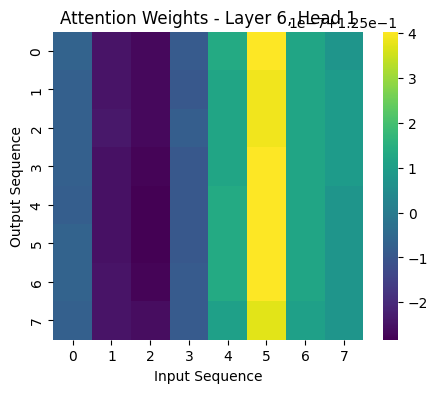

In [472]:
# Call to visualize temporal attention (Days x Days)
plot_attention_heatmap(attention_weights=encoder_attn_weights, layer=5, head=0, feature_axis=False)


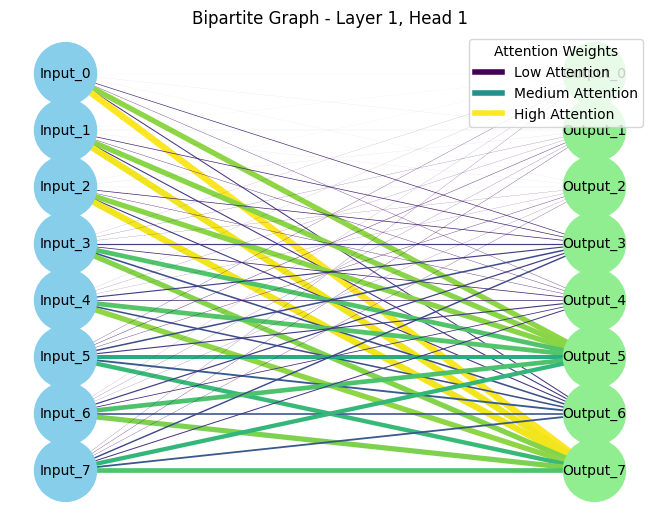

In [473]:
plot_bipartite_graph_with_legend(encoder_attn_weights, layer=0, head=0)

In [474]:
test_labels.shape

(1080, 2115, 8, 1)

In [499]:
avg_predictions = []
avg_observed = []

for x in range(len(test_features)):
    outputs, encoder_attn_weights, decoder_self_attn_weights, decoder_cross_attn_weights = model(test_features_[x], test_labels_[x]) # Forward pass
    test_predictions = outputs.detach().cpu().numpy()
    predict = np.max(test_predictions[:, 0, 0])
    actual = np.mean(test_labels[x, :, 0, 0])

    avg_predictions.append(predict)
    avg_observed.append(actual)

In [500]:
avg_predictions = np.array(avg_predictions)
avg_observed = np.array(avg_observed)

print(avg_predictions.shape)
print(avg_observed.shape)

(1080,)
(1080,)


<Figure size 640x480 with 0 Axes>

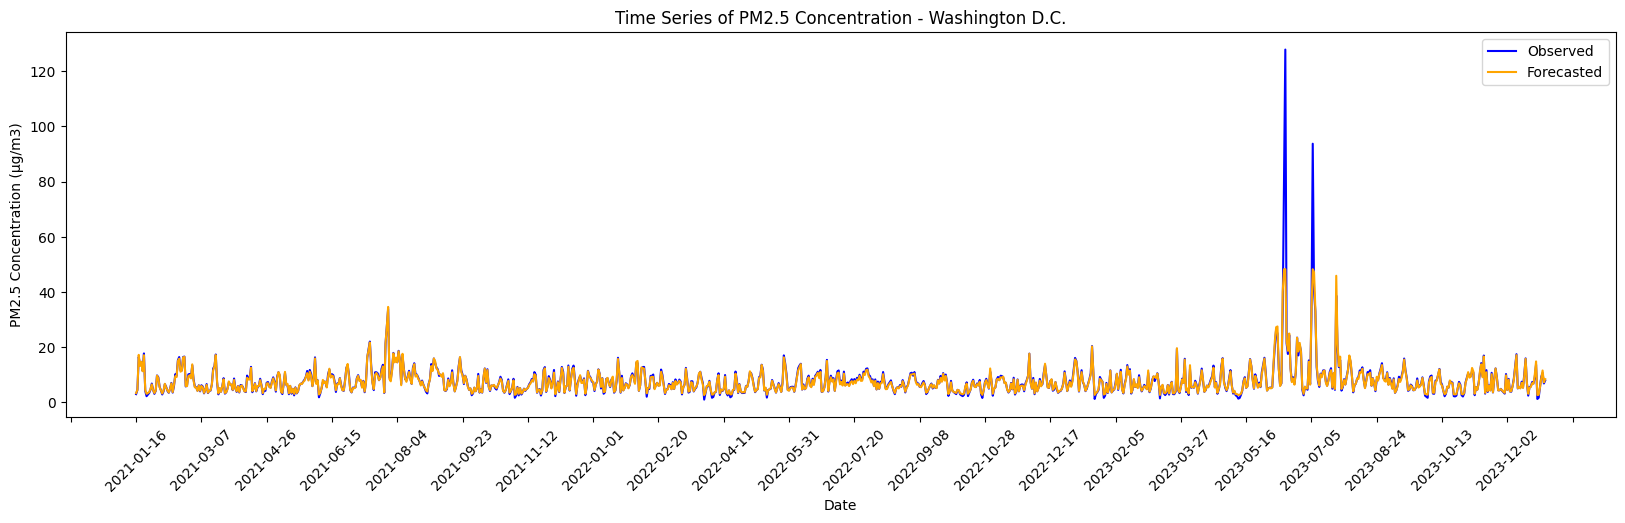

In [501]:
avg_predictions = np.array(avg_predictions)

# Generate a range of dates
date_range = pd.date_range(start="2021-01-16", end="2023-12-31", freq='D')


# Convert the date range to a string
date_strings = date_range.strftime('%Y-%m-%d')
plt.clf()
plt.figure(figsize=(20,5))
plt.plot(date_strings, avg_observed, label="Observed", color = "blue")
plt.plot(date_strings, avg_predictions, label = "Forecasted", color = "orange")

# Set the interval for the x-axis labels
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=24))  # Display up to 12 labels


# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plt.title(f'Time Series of PM2.5 Concentration - Washington D.C.')
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration (µg/m3)")

plt.legend()

plt.show()

In [502]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(avg_observed, avg_predictions))

# Calculate MAE
mae = mean_absolute_error(avg_observed, avg_predictions)

# Calculate R²
r2 = r2_score(avg_observed, avg_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 3.020091788337784
MAE: 0.5109685378932471
R²: 0.7910631677991413


In [479]:
def correlation_graph(aeronet_full, modis_full, model):
    # get data to be plotted - plot_modis_aeronet includes gaps
    
    # density coloring

    xy = np.vstack([aeronet_full, modis_full])
    z = scipy.stats.gaussian_kde(xy)(xy)
    

    plt.scatter(aeronet_full, modis_full, 10, c=z)
    plt.colorbar(orientation="vertical")
    
    # naming the x axis
    plt.xlabel('Actual PM2.5')
    
    # naming the y axis
    plt.ylabel('Predicted PM2.5')

    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(aeronet_full, modis_full, 1).round(5)


    #add linear regression line to scatterplot 
    plt.plot(aeronet_full, m*aeronet_full+b, 'r', label = 'y = ' + str(m) + "*x + " + str(b))

    #EE lines
    x = np.array([i for i in range(5)])
    plt.plot(x, x+0.05 + 0.2 * x, linestyle = "dashed", color = "grey")
    plt.plot(x, x-0.05 - 0.2 * x, linestyle = "dashed", color = "grey")

    plt.plot(range(5), range(5), color = "black")

    plt.legend(loc="upper left")
    plt.title(model)

    # To show the plot
    plt.show()
    print("n=", len(modis_full))
    print("r^2=", sk.r2_score(modis_full, aeronet_full))
    r, p = scipy.stats.pearsonr(aeronet_full, modis_full)
    print("Pearsonr=", r)
    print("RMSE=", sk.mean_squared_error(modis_full, aeronet_full, squared=False))
    print("MAE=", sk.mean_absolute_error(modis_full, aeronet_full))
    print("RMB=", np.mean(modis_full)/np.mean(aeronet_full))
    count = 0
    for a, m in zip(aeronet_full, modis_full):
        if 0.8 * a - 0.05 <= m <= 1.2 * a + 0.05:
            count += 1

    print("%EE=", 100 * count/len(aeronet_full))

In [489]:
# Validation phase
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def validation(base_train_loader):
    model.eval()  # Set model to evaluation mode
    rmse_running_val = 0.0
    mae_running_val = 0.0
    r2_running_val = 0.0

    predicted = []
    truth = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in base_train_loader:
            outputs, encoder_attn_weights, decoder_self_attn_weights, decoder_cross_attn_weights = model(inputs, targets) # Forward pass
            rmse, mae, r2 = criterion(outputs, targets)  # Compute loss
            rmse_running_val += val_rmse
            mae_running_val += val_mae
            r2_running_val += val_r2

            predicted.append(outputs)
            truth.append(targets)

    val_rmse_loss = rmse_running_val / len(train_loader)
    val_mae_loss = mae_running_val / len(train_loader)
    val_r2_loss = r2_running_val / len(train_loader)


    print(f'Validation RMSE: {val_rmse_loss:.4f}, MAE: {val_mae_loss:.4f}, R2: {val_r2_loss:.4f}')

    predictions = torch.cat(predicted, dim=0).cpu()
    predictions = np.array(predictions)

    true = torch.cat(truth, dim=0).cpu()
    true = np.array(true)

    
    # Calculate RMSE
    day = 0
    prediction_flat = predictions[:, day].ravel()
    truth_flat = true[:, day].ravel()

    rmse = np.sqrt(mean_squared_error(truth_flat, prediction_flat))

    # Calculate MAE
    mae = mean_absolute_error(truth_flat, prediction_flat)

    # Calculate R²
    r2 = r2_score(truth_flat, prediction_flat)

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")

    print(prediction_flat.shape)

    np.random.seed(42)
    index = np.random.choice(prediction_flat.shape[0], min(10000, prediction_flat.shape[0]), replace=False)
    a = prediction_flat[index]
    b = truth_flat[index]
    correlation_graph(b, a, "No Data Augmentation")

Validation RMSE: 7.8588, MAE: 2.9094, R2: 2.3487
RMSE: 3.243105888366699
MAE: 0.7690013647079468
R²: 0.7930088043212891
(94976,)


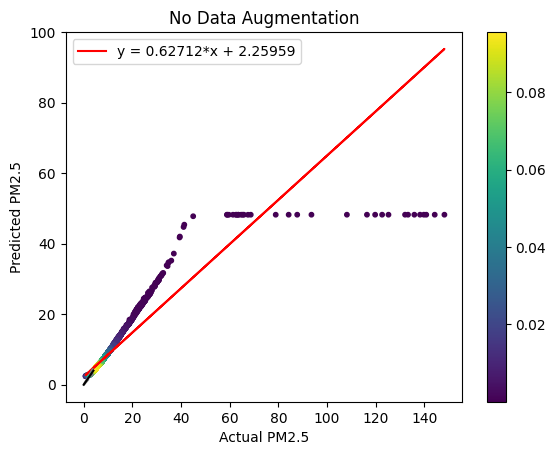

n= 10000
r^2= 0.5201513767242432
Pearsonr= 0.9131046841046637
RMSE= 3.2425768
MAE= 0.7536392
RMB= 0.9174356
%EE= 95.9


c:\Users\asrireng\AppData\Local\anaconda3\envs\test_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [490]:
validation(base_train_loader)

Validation RMSE: 0.3389, MAE: 0.1255, R2: 0.1013
RMSE: 42.01055145263672
MAE: 29.329330444335938
R²: -0.6591743230819702
(4096,)


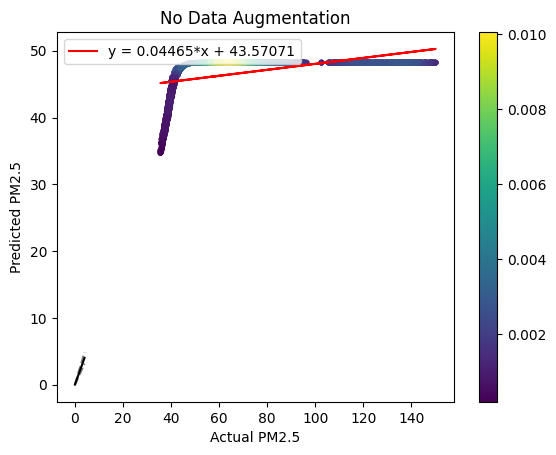

n= 4096
r^2= -203.06712341308594
Pearsonr= 0.49520269356256064
RMSE= 42.010548
MAE= 29.32933
RMB= 0.62573785
%EE= 36.181640625


c:\Users\asrireng\AppData\Local\anaconda3\envs\test_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [482]:
validation(high_train_loader)

In [483]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total/1e9}')
print(f'free     : {info.free/1e9}')
print(f'used     : {info.used/1e9}')

total    : 51.52702464
free     : 40.362053632
used     : 11.164971008


In [484]:
def inference(self, src):
        batch = src.shape[0]
        
        # Generate the mask for src
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2).to('cuda').reshape(batch, 1, 8, 8)
        
        # Apply positional encoding and dropout
        src_embedded = self.dropout(self.positional_encoding(src))

        #print(f'src embedded: {src_embedded.shape}')

        # Encode the input sequence
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        #print("finished encoding")
        
        # Initialize the target sequence with a start token or zeros (you can adjust as needed)
        tgt = torch.zeros((src.size(0), 1, 1), dtype=torch.long).to('cuda')  # Start with a placeholder
        #tgt = src[:, -1:, -1:].clone().to('cuda')
        
        outputs = []
        
        # Generate the next 8 days in one go
        for _ in range(8):
            tgt_embedded = self.dropout(self.positional_encoding(tgt))
            
            # Generate the mask for tgt
            tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2).to('cuda')
            seq_length = tgt.size(1)
            nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to('cuda')
            tgt_mask = tgt_mask & nopeak_mask

            #print(f'tgt mask: {tgt_mask.shape}')

            tgt_mask = tgt_mask.reshape(tgt_mask.shape[0], 1, 1, 1)
            
            dec_output = tgt_embedded
            for dec_layer in self.decoder_layers:
                dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
            
            output = self.fc(dec_output[:, -1, :])  # Get the last token's prediction
            outputs.append(output.unsqueeze(1))
            
            # Greedily choose the next token
            next_token = output.argmax(dim=-1, keepdim=True)

            #print(f'next token: {next_token.shape}')
            next_token = next_token.reshape(next_token.shape[0], 1, 1)
            tgt = next_token
        
        outputs = torch.cat(outputs, dim=1)
        return outputs